In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.datasets import fetch_openml
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
import xgboost as xgb
from feature_engine.outliers import Winsorizer
from tqdm import tqdm
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
import pmdarima as pm

## Project Objective

This project focuses on **handling real-world time series data** from **robotic sensor systems** operating in extreme planetary environments.

By working with environmental data from the **Curiosity Rover’s REMS**, the goal is to:

- Develop techniques for **cleaning, processing, and modeling sensor data**  
- Build a foundation for **autonomous operations** and **anomaly detection** in space robotics  
- Support future missions by enhancing **data reliability** and **predictive capabilities** in **hostile, data-limited environments** like Mars

Understanding and forecasting environmental patterns is critical to enabling **robotic systems to operate independently**, adapt to changing conditions, and flag potential hazards in real time.

Through this notebook, I will:

- Perform **data cleaning and exploration** to understand the structure and trends in the sensor data.
- Analyze **seasonality, trends, and anomalies** within the sensor readings to simulate how sensor data can indicate environmental patterns on Mars.
- Prepare for **time series forecasting** of sensor variables, which is essential for building predictive models for environmental monitoring in robotic habitats.

SOURCE: https://www.kaggle.com/datasets/thedevastator/mars-weather-data-from-2012-to-2018

In [2]:
# Read in the .csv file
data = pd.read_csv("mars-weather.csv")
pd.set_option('display.max_rows', None)
#display basic information about data

data.head(10)

id terrestrial_date   sol   ls    month  min_temp  max_temp  pressure  \
0  1895       2018-02-27  1977  135  Month 5     -77.0     -10.0     727.0   
1  1893       2018-02-26  1976  135  Month 5     -77.0     -10.0     728.0   
2  1894       2018-02-25  1975  134  Month 5     -76.0     -16.0     729.0   
3  1892       2018-02-24  1974  134  Month 5     -77.0     -13.0     729.0   
4  1889       2018-02-23  1973  133  Month 5     -78.0     -18.0     730.0   
5  1891       2018-02-22  1972  133  Month 5     -78.0     -14.0     730.0   
6  1890       2018-02-21  1971  132  Month 5     -78.0     -13.0     731.0   
7  1888       2018-02-20  1970  132  Month 5     -77.0     -16.0     731.0   
8  1887       2018-02-19  1969  131  Month 5     -76.0     -16.0     732.0   
9  1886       2018-02-18  1968  131  Month 5     -76.0     -19.0     732.0   

   wind_speed atmo_opacity  
0         NaN        Sunny  
1         NaN        Sunny  
2         NaN        Sunny  
3         NaN        Sunny  
4         NaN        Sunny  
5         NaN        Sunny  
6         NaN        Sunny  
7         NaN        Sunny  
8         NaN        Sunny  
9         NaN        Sunny

In [3]:
data.describe()

id          sol           ls     min_temp     max_temp  \
count  1894.000000  1894.000000  1894.000000  1867.000000  1867.000000   
mean    948.372228  1007.930306   169.180570   -76.121050   -12.510445   
std     547.088173   567.879561   105.738532     5.504098    10.699454   
min       1.000000     1.000000     0.000000   -90.000000   -35.000000   
25%     475.250000   532.250000    78.000000   -80.000000   -23.000000   
50%     948.500000  1016.500000   160.000000   -76.000000   -11.000000   
75%    1421.750000  1501.750000   259.000000   -72.000000    -3.000000   
max    1895.000000  1977.000000   359.000000   -62.000000    11.000000   

          pressure  wind_speed  
count  1867.000000         0.0  
mean    841.066417         NaN  
std      54.253226         NaN  
min     727.000000         NaN  
25%     800.000000         NaN  
50%     853.000000         NaN  
75%     883.000000         NaN  
max     925.000000         NaN

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1894 non-null   int64  
 1   terrestrial_date  1894 non-null   object 
 2   sol               1894 non-null   int64  
 3   ls                1894 non-null   int64  
 4   month             1894 non-null   object 
 5   min_temp          1867 non-null   float64
 6   max_temp          1867 non-null   float64
 7   pressure          1867 non-null   float64
 8   wind_speed        0 non-null      float64
 9   atmo_opacity      1894 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 148.1+ KB


In [5]:
# NOTE: the column name "ls" stands for solar longitude. Column name changed for clarity
data = data.rename(columns = {"ls": "solar_long"})

# convert values in terrestrial_date to Datetime
data["terrestrial_date"] = pd.to_datetime(data["terrestrial_date"])

Primary quantitative sensor features (These will serve as the primary features explored throughout this notebook):
- **min_temp** (minimum ground temperature in Celsius)
- **max temp** (maximum ground temperature in Celsius)
- **pressure** (mean air pressure)

Temporal alignment and seasonality tracking:
- terrestrial_date (earth date)
- sol (martian day)
- solar_long (solar longitude)
- month (number of martian month)

No data is provided for wind_speed and can be dropped.

Data for atmos_opacity is recorded as constant. This may not be accurate but will still be considered for this sake of this project.

In [6]:
data = data.drop(["id", "wind_speed"], axis=1).sort_values("sol")

In [7]:
# prioritize only necessary quantitative variables for time series
quant_data = data.drop(["terrestrial_date"], axis=1)
quant_data.head()

sol  solar_long    month  min_temp  max_temp  pressure atmo_opacity
1893    1         150  Month 6       NaN       NaN       NaN        Sunny
1892    9         155  Month 6       NaN       NaN       NaN        Sunny
1891   10         155  Month 6     -75.0     -16.0     739.0        Sunny
1890   11         156  Month 6     -76.0     -11.0     740.0        Sunny
1889   12         156  Month 6     -76.0     -18.0     741.0        Sunny

# Indenitifying Seasonality

The following plots illustrates the minimum and maximum ground temperature values over time (measured in Martian sols) as well as air pressure (measure in Pascals). Both graphs are visualized separately to isolate the difference in seasonality between the two and the rolling mean will be used to emphasize trend.

Text(0, 0.5, 'Temperature')

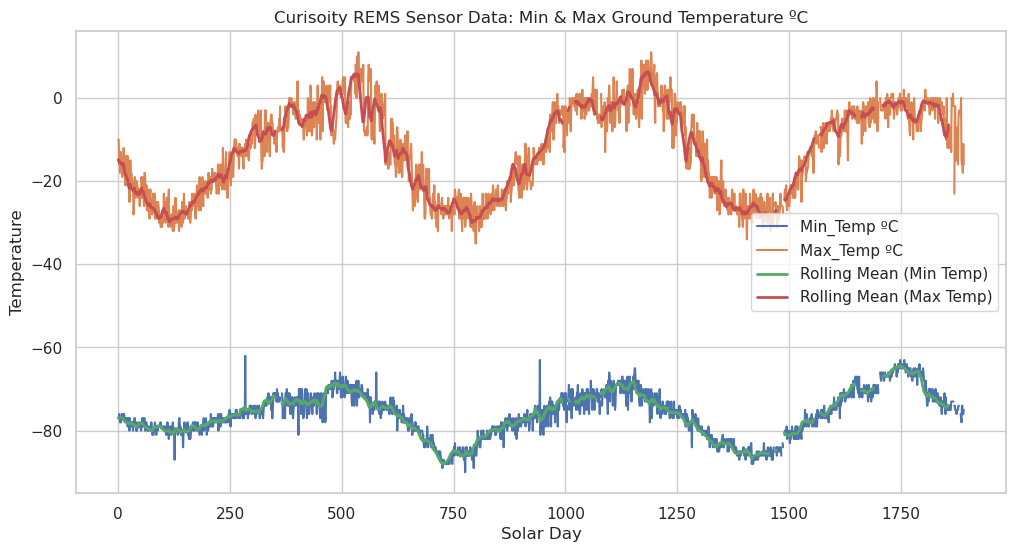

In [8]:
# Calculate rolling means
quant_data['min_temp_roll'] = quant_data['min_temp'].rolling(window=12).mean()
quant_data['max_temp_roll'] = quant_data['max_temp'].rolling(window=12).mean()

plt.figure(figsize=(12,6))
plt.plot(data.index, quant_data["min_temp"], label = "Min_Temp ºC")
plt.plot(data.index, quant_data["max_temp"], label = "Max_Temp ºC")
plt.plot(data.index, quant_data["min_temp_roll"], label = "Rolling Mean (Min Temp)", linewidth=2)
plt.plot(data.index, quant_data["max_temp_roll"], label = "Rolling Mean (Max Temp)", linewidth=2)
plt.title("Curisoity REMS Sensor Data: Min & Max Ground Temperature ºC")
plt.xlabel("Solar Day")
plt.legend()
plt.ylabel("Temperature")

Text(0, 0.5, 'Pressure Pa')

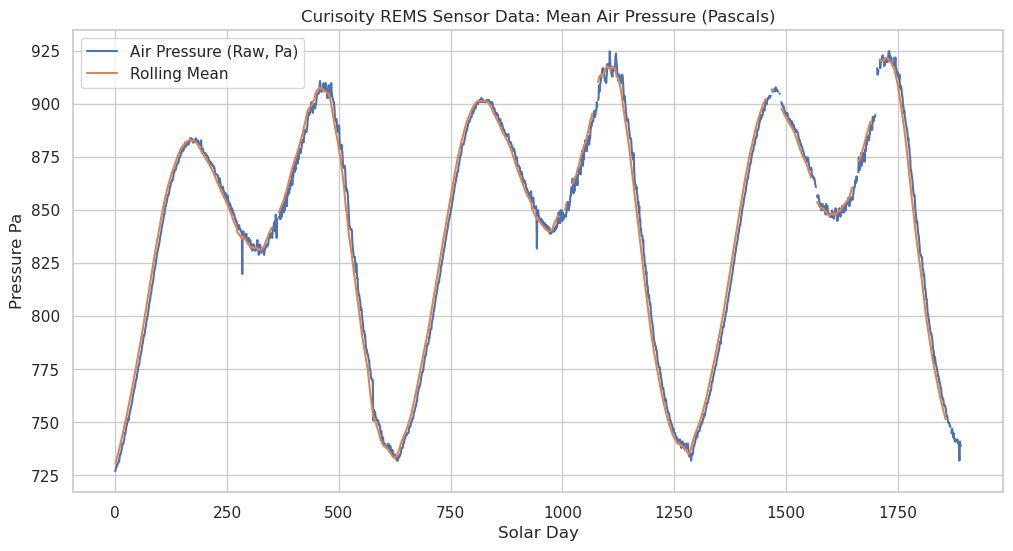

In [9]:
quant_data['pressure_roll'] = quant_data['pressure'].rolling(window=12).mean()

plt.figure(figsize=(12,6))
plt.plot(data.index, quant_data["pressure"], label="Air Pressure (Raw, Pa)")
plt.plot(data.index, quant_data["pressure_roll"], label="Rolling Mean")
plt.title("Curisoity REMS Sensor Data: Mean Air Pressure (Pascals)")
plt.xlabel("Solar Day")
plt.legend()
plt.ylabel("Pressure Pa")

# Handling Missing Data
## Reindexing and Imputation

The dataset contains numerous days for which no sensor data was recorded, resulting in significant gaps across the time series. To better prepare the data for analysis, the dataset will be reindexed to enforce a continuous daily time index along the `sols` column. A backfill and linear imputation method will be used to handle the subsequent missing data and any other pre-existing NaN values.

***It is important to note that this reindexing, along with the methods used to impute missing values, will introduce a degree of uncertainty into the dataset, which should be considered when interpreting subsequent analyses and forecasts.***

In [10]:
# Find missing sols in the sequence
all_sols = set(range(quant_data["sol"].min(), quant_data["sol"].max() + 1))
existing_sols = set(quant_data["sol"])
missing_sols = sorted(list(all_sols - existing_sols))

print("Missing sols:", missing_sols)

Missing sols: [2, 3, 4, 5, 6, 7, 8, 193, 194, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 263, 264, 265, 266, 359, 360, 361, 362, 363, 364, 445, 446, 447, 448, 449, 450, 451, 452, 453, 458, 459, 460, 461, 479, 480, 481, 482, 483, 484, 873, 874, 875, 876, 877, 878, 879, 938, 955, 956, 999, 1027, 1289, 1290, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1691, 1786]


An analysis of the proportion and distribution of these missing days confirms the presence of several large intervals without observations.

In [11]:
#Re-index sol column
quant_data = quant_data.set_index('sol').sort_index()
full_index = pd.Index(range(quant_data.index.min(), quant_data.index.max() + 1), name='sol')
data_reindexed = quant_data.reindex(full_index)
data_sols = data_reindexed.reset_index()
data_sols.head()

sol  solar_long    month  min_temp  max_temp  pressure atmo_opacity  \
0    1       150.0  Month 6       NaN       NaN       NaN        Sunny   
1    2         NaN      NaN       NaN       NaN       NaN          NaN   
2    3         NaN      NaN       NaN       NaN       NaN          NaN   
3    4         NaN      NaN       NaN       NaN       NaN          NaN   
4    5         NaN      NaN       NaN       NaN       NaN          NaN   

   min_temp_roll  max_temp_roll  pressure_roll  
0            NaN            NaN            NaN  
1            NaN            NaN            NaN  
2            NaN            NaN            NaN  
3            NaN            NaN            NaN  
4            NaN            NaN            NaN

In [12]:
# Bfill to fill "month" and "atmo_opacity" NaN values
data_sols['month'] = data_sols['month'].bfill()
data_sols['atmo_opacity'] = data_sols['atmo_opacity'].bfill()

# Re-check number of NaN values to ensure NaN values were eliminated
data_sols.isnull().sum()

sol                0
solar_long        83
month              0
min_temp         110
max_temp         110
pressure         110
atmo_opacity       0
min_temp_roll    245
max_temp_roll    245
pressure_roll    245
dtype: int64

In [13]:
data_sols.head(15).iloc[:, :2]

sol  solar_long
0     1       150.0
1     2         NaN
2     3         NaN
3     4         NaN
4     5         NaN
5     6         NaN
6     7         NaN
7     8         NaN
8     9       155.0
9    10       155.0
10   11       156.0
11   12       156.0
12   13       157.0
13   14       157.0
14   15       158.0

#### Handling Missing Solar Longitude (Lₛ) Values

The `solar_long` column, which represents the solar longitude (Lₛ) or seasonal position of Mars in its orbit, contained several missing values early in the dataset. Since Lₛ progresses smoothly and cyclically with time on Mars, missing values will be filled using double directional **linear interpolation** to simulate a consistent trend.

Because values are generated only where data was missing, the resulting sequence reflects a realistic progression of Mars’ seasonal orbit.

In [14]:
# Interpolate missing values using double directional fill
#----DISPLAY ONLY SOLAR COLUMN-----
data_sols['solar_long'] = data_sols['solar_long'].interpolate(method='linear', limit_direction='both')
data_sols['solar_long'] = data_sols['solar_long'].round(0).astype(float)
data_sols.head(10).iloc[:, :2]

sol  solar_long
0    1       150.0
1    2       151.0
2    3       151.0
3    4       152.0
4    5       152.0
5    6       153.0
6    7       154.0
7    8       154.0
8    9       155.0
9   10       155.0

#### Imputation of Missing Sensor Values with Interpolation and Gaussian Noise

A two step imputation process is performed to address missing values in the environmental sensor data (`min_temp`, `max_temp`, and `pressure`):

1. **Linear Interpolation**  
   Missing values will be first imputed using linear interpolation (`method='linear'`, `limit_direction='both'`). This fills gaps based on the trend of surrounding values, providing a smooth and continuous estimation across the dataset which is especially important for time series analysis.

2. **Gaussian Jitter (Random Noise Addition)**  
   To preserve natural variability and avoid over-smoothing, small random noise will be added to only the previously missing (now interpolated) values. This is done by:
   - Identifying the original missing locations using `.isna()`
   - Generating random values from a Gaussian distribution (mean = 0, standard deviation = 0.5)
   - Adding this noise **only** to the interpolated values

This hybrid approach will help simulate realistic Martian sensor readings while preserving the underlying trends for downstream modeling and analysis.


In [15]:
# Interpolate missing numeric values
sensor_cols = ['min_temp', 'max_temp', 'pressure', 'min_temp_roll', 'max_temp_roll', 'pressure_roll']
data_interp = data_sols.copy()
data_interp[sensor_cols] = data_interp[sensor_cols].interpolate(method='linear', limit_direction = 'both')

# Add Gaussian jitter ONLY to originally missing values to preserve variability
noise_scale = 0.5  # adjust as needed
for col in sensor_cols:
    # Apply noise only to originally missing locations
    mask = data_sols[col].isna() #Identifies original NaNs
    # Noise array
    noise = np.random.normal(loc=0, scale=noise_scale, size=mask.sum())
    data_interp.loc[mask, col] += noise
    
# Check results
data_interp

sol  solar_long     month   min_temp   max_temp    pressure  \
0        1       150.0   Month 6 -74.609508 -16.224465  739.229050   
1        2       151.0   Month 6 -74.477499 -15.208288  738.929487   
2        3       151.0   Month 6 -75.711346 -16.728044  739.446682   
3        4       152.0   Month 6 -75.438515 -16.561733  738.780122   
4        5       152.0   Month 6 -74.663263 -15.988497  738.379631   
5        6       153.0   Month 6 -74.253296 -15.514500  739.184353   
6        7       154.0   Month 6 -74.271549 -16.147155  738.837127   
7        8       154.0   Month 6 -75.391641 -16.668838  739.030695   
8        9       155.0   Month 6 -74.635347 -16.052670  739.114327   
9       10       155.0   Month 6 -75.000000 -16.000000  739.000000   
10      11       156.0   Month 6 -76.000000 -11.000000  740.000000   
11      12       156.0   Month 6 -76.000000 -18.000000  741.000000   
12      13       157.0   Month 6 -74.000000 -15.000000  732.000000   
13      14       157.0   Month 6 -74.000000 -16.000000  740.000000   
14      15       158.0   Month 6 -78.000000 -15.000000  740.000000   
15      16       158.0   Month 6 -77.000000   0.000000  740.000000   
16      17       159.0   Month 6 -76.000000  -4.000000  742.000000   
17      18       160.0   Month 6 -74.623195  -4.442218  741.975314   
18      19       160.0   Month 6 -74.321051  -2.613919  741.834629   
19      20       161.0   Month 6 -74.537809  -3.028938  740.966811   
20      21       161.0   Month 6 -74.000000  -3.000000  741.000000   
21      22       162.0   Month 6 -74.000000  -6.000000  742.000000   
22      23       162.0   Month 6 -75.000000 -16.000000  741.000000   
23      24       163.0   Month 6 -75.000000  -7.000000  742.000000   
24      25       163.0   Month 6 -75.000000 -11.000000  743.000000   
25      26       164.0   Month 6 -76.000000 -14.000000  745.000000   
26      27       164.0   Month 6 -75.000000 -15.000000  743.000000   
27      28       165.0   Month 6 -75.000000 -15.000000  745.000000   
28      29       166.0   Month 6 -75.000000  -2.000000  747.000000   
29      30       166.0   Month 6 -74.000000  -3.000000  747.000000   
30      31       167.0   Month 6 -74.000000 -23.000000  745.000000   
31      32       167.0   Month 6 -72.556449 -11.617097  746.526497   
32      33       168.0   Month 6 -73.000000  -2.000000  748.000000   
33      34       168.0   Month 6 -73.000000   1.000000  748.000000   
34      35       169.0   Month 6 -73.000000  -1.000000  749.000000   
35      36       169.0   Month 6 -73.000000  -1.000000  750.000000   
36      37       170.0   Month 6 -73.000000   0.000000  750.000000   
37      38       171.0   Month 6 -73.000000 -13.000000  750.000000   
38      39       171.0   Month 6 -75.000000  -8.000000  751.000000   
39      40       172.0   Month 6 -75.000000 -12.000000  753.000000   
40      41       172.0   Month 6 -75.000000 -12.000000  753.000000   
41      42       173.0   Month 6 -75.000000  -7.000000  754.000000   
42      43       173.0   Month 6 -74.000000 -12.000000  756.000000   
43      44       174.0   Month 6 -75.000000 -10.000000  757.000000   
44      45       175.0   Month 6 -74.000000  -9.000000  758.000000   
45      46       175.0   Month 6 -74.000000 -12.000000  758.000000   
46      47       176.0   Month 6 -75.000000  -9.000000  758.000000   
47      48       176.0   Month 6 -75.000000   0.000000  759.000000   
48      49       177.0   Month 6 -74.000000 -10.000000  761.000000   
49      50       177.0   Month 6 -72.000000 -10.000000  761.000000   
50      51       178.0   Month 6 -76.000000  -7.000000  762.000000   
51      52       179.0   Month 6 -74.000000  -7.000000  762.000000   
52      53       179.0   Month 6 -71.000000  -5.000000  764.000000   
53      54       180.0   Month 7 -72.000000  -9.000000  766.000000   
54      55       180.0   Month 7 -74.000000  -2.000000  766.000000   
55      56       181.0   Month 7 -73.000000  -4.000000  768.000000   
56      57       

In [16]:
data_interp.isnull().sum()

sol              0
solar_long       0
month            0
min_temp         0
max_temp         0
pressure         0
atmo_opacity     0
min_temp_roll    0
max_temp_roll    0
pressure_roll    0
dtype: int64

#### Identifying Outliers

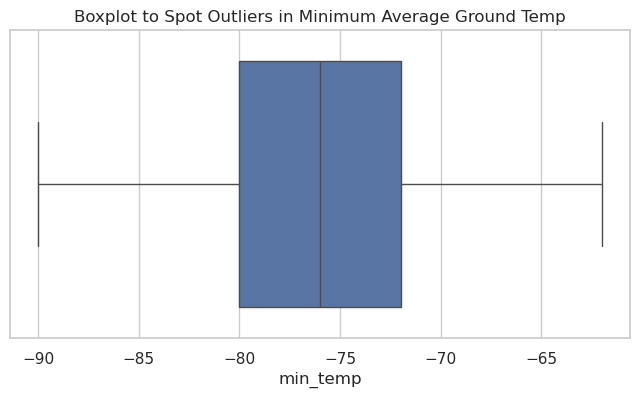

Outlier Positions (Index): []


In [17]:
# Visualize using Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=data_interp['min_temp'])
plt.title("Boxplot to Spot Outliers in Minimum Average Ground Temp")
plt.show()

# Using Z-Score to Detect Outliers
z_scores = np.abs(stats.zscore(data_interp['min_temp'].dropna()))
threshold = 3
outlier_positions = np.where(z_scores > threshold)[0]
print("Outlier Positions (Index):", outlier_positions)

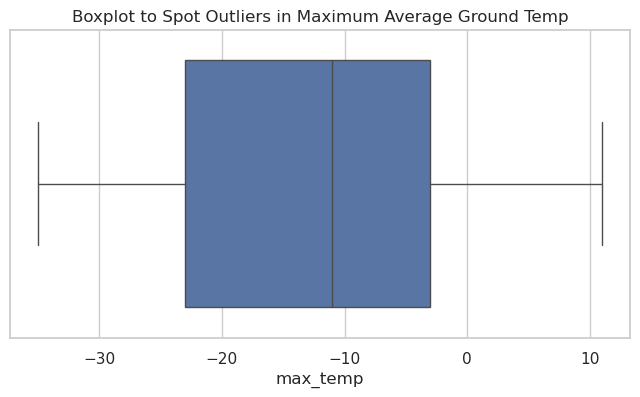

Outlier Positions (Index): []


In [18]:
# Visualize using Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=data_interp['max_temp'])
plt.title("Boxplot to Spot Outliers in Maximum Average Ground Temp")
plt.show()

# Using Z-Score to Detect Outliers
z_scores = np.abs(stats.zscore(data_interp['max_temp'].dropna()))
threshold = 3
outlier_positions = np.where(z_scores > threshold)[0]
print("Outlier Positions (Index):", outlier_positions)

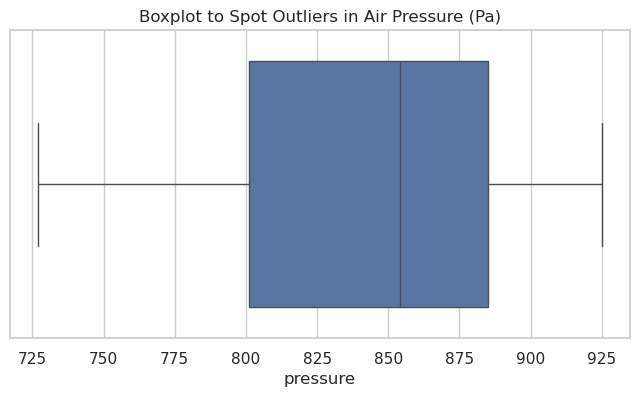

Outlier Positions (Index): []


In [19]:
# Visualize using Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=data_interp['pressure'])
plt.title("Boxplot to Spot Outliers in Air Pressure (Pa)")
plt.show()

# Using Z-Score to Detect Outliers
z_scores = np.abs(stats.zscore(data_interp['pressure'].dropna()))
threshold = 3
outlier_positions = np.where(z_scores > threshold)[0]
print("Outlier Positions (Index):", outlier_positions)

In [20]:
#group by month to see number of sols per month
month_counts = data_interp.groupby('month').size()
month_counts

month
Month 1     184
Month 10    143
Month 11    152
Month 12    167
Month 2     196
Month 3     200
Month 4     194
Month 5     151
Month 6     160
Month 7     151
Month 8     141
Month 9     138
dtype: int64

### Understanding Martian Time: Sols, Years, and Months

To properly analyze this dataset in the context of seasonality, it's essential to understand how time is measured on Mars.

- A **Martian day**, known as a **sol**, lasts approximately **24 hours and 39 minutes**, slightly longer than an Earth day.  
- A **Martian year** is significantly longer due to Mars’s slower orbit and spans about **669 sols**.

Mars does not use Earth’s Gregorian calendar. Instead, researchers often refer to the **Darian calendar system**, which divides a Martian year into **24 months** to better align with seasonal patterns.

- The **first five months** each contain **28 sols**.  
- The **sixth month** has **27 sols**, except during **leap years**, which occur roughly **six times per Martian decade** to maintain calendar accuracy.

Because this dataset has a month column that incorrectly loops back to Month 1 after Month 12, there is an incorrect mapping of the month column.


In [21]:
updated_data = data_interp.copy()

# Find where each new Martian year starts by detecting when 'month' jumps from 12 to 1
month_numbers = updated_data['month'].str.extract(r'(\d+)').astype(int)
year_shift_points = month_numbers.diff().fillna(0) < 0  # True where it wraps back to Month 1

# Create a cumulative year counter
martian_year = year_shift_points.cumsum()

# Combine year and month index to create Month 1–24 across years
month_index_within_year = month_numbers + martian_year * 12

# Format final 'month' label
updated_data['month'] = 'Month ' + month_index_within_year.astype(str)
updated_data

sol  solar_long     month   min_temp   max_temp    pressure  \
0        1       150.0   Month 6 -74.609508 -16.224465  739.229050   
1        2       151.0   Month 6 -74.477499 -15.208288  738.929487   
2        3       151.0   Month 6 -75.711346 -16.728044  739.446682   
3        4       152.0   Month 6 -75.438515 -16.561733  738.780122   
4        5       152.0   Month 6 -74.663263 -15.988497  738.379631   
5        6       153.0   Month 6 -74.253296 -15.514500  739.184353   
6        7       154.0   Month 6 -74.271549 -16.147155  738.837127   
7        8       154.0   Month 6 -75.391641 -16.668838  739.030695   
8        9       155.0   Month 6 -74.635347 -16.052670  739.114327   
9       10       155.0   Month 6 -75.000000 -16.000000  739.000000   
10      11       156.0   Month 6 -76.000000 -11.000000  740.000000   
11      12       156.0   Month 6 -76.000000 -18.000000  741.000000   
12      13       157.0   Month 6 -74.000000 -15.000000  732.000000   
13      14       157.0   Month 6 -74.000000 -16.000000  740.000000   
14      15       158.0   Month 6 -78.000000 -15.000000  740.000000   
15      16       158.0   Month 6 -77.000000   0.000000  740.000000   
16      17       159.0   Month 6 -76.000000  -4.000000  742.000000   
17      18       160.0   Month 6 -74.623195  -4.442218  741.975314   
18      19       160.0   Month 6 -74.321051  -2.613919  741.834629   
19      20       161.0   Month 6 -74.537809  -3.028938  740.966811   
20      21       161.0   Month 6 -74.000000  -3.000000  741.000000   
21      22       162.0   Month 6 -74.000000  -6.000000  742.000000   
22      23       162.0   Month 6 -75.000000 -16.000000  741.000000   
23      24       163.0   Month 6 -75.000000  -7.000000  742.000000   
24      25       163.0   Month 6 -75.000000 -11.000000  743.000000   
25      26       164.0   Month 6 -76.000000 -14.000000  745.000000   
26      27       164.0   Month 6 -75.000000 -15.000000  743.000000   
27      28       165.0   Month 6 -75.000000 -15.000000  745.000000   
28      29       166.0   Month 6 -75.000000  -2.000000  747.000000   
29      30       166.0   Month 6 -74.000000  -3.000000  747.000000   
30      31       167.0   Month 6 -74.000000 -23.000000  745.000000   
31      32       167.0   Month 6 -72.556449 -11.617097  746.526497   
32      33       168.0   Month 6 -73.000000  -2.000000  748.000000   
33      34       168.0   Month 6 -73.000000   1.000000  748.000000   
34      35       169.0   Month 6 -73.000000  -1.000000  749.000000   
35      36       169.0   Month 6 -73.000000  -1.000000  750.000000   
36      37       170.0   Month 6 -73.000000   0.000000  750.000000   
37      38       171.0   Month 6 -73.000000 -13.000000  750.000000   
38      39       171.0   Month 6 -75.000000  -8.000000  751.000000   
39      40       172.0   Month 6 -75.000000 -12.000000  753.000000   
40      41       172.0   Month 6 -75.000000 -12.000000  753.000000   
41      42       173.0   Month 6 -75.000000  -7.000000  754.000000   
42      43       173.0   Month 6 -74.000000 -12.000000  756.000000   
43      44       174.0   Month 6 -75.000000 -10.000000  757.000000   
44      45       175.0   Month 6 -74.000000  -9.000000  758.000000   
45      46       175.0   Month 6 -74.000000 -12.000000  758.000000   
46      47       176.0   Month 6 -75.000000  -9.000000  758.000000   
47      48       176.0   Month 6 -75.000000   0.000000  759.000000   
48      49       177.0   Month 6 -74.000000 -10.000000  761.000000   
49      50       177.0   Month 6 -72.000000 -10.000000  761.000000   
50      51       178.0   Month 6 -76.000000  -7.000000  762.000000   
51      52       179.0   Month 6 -74.000000  -7.000000  762.000000   
52      53       179.0   Month 6 -71.000000  -5.000000  764.000000   
53      54       180.0   Month 7 -72.000000  -9.000000  766.000000   
54      55       180.0   Month 7 -74.000000  -2.000000  766.000000   
55      56       181.0   Month 7 -73.000000  -4.000000  768.000000   
56      57       

In [22]:
month_counts = updated_data.groupby('month').size().reset_index(name='num_sols')
month_counts

month  num_sols
0   Month 10        47
1   Month 11        51
2   Month 12        56
3   Month 13        61
4   Month 14        65
5   Month 15        67
6   Month 16        65
7   Month 17        59
8   Month 18        55
9   Month 19        49
10  Month 20        47
11  Month 21        46
12  Month 22        48
13  Month 23        51
14  Month 24        55
15  Month 25        62
16  Month 26        65
17  Month 27        67
18  Month 28        64
19  Month 29        60
20  Month 30        52
21  Month 31        52
22  Month 32        47
23  Month 33        46
24  Month 34        48
25  Month 35        50
26  Month 36        56
27  Month 37        61
28  Month 38        66
29  Month 39        66
30  Month 40        65
31  Month 41        32
32   Month 6        53
33   Month 7        50
34   Month 8        47
35   Month 9        46

### Seasonal Decomposition
To better understand the underlying structure of the environmental sensor data, seasonal decomposition will be applied to each feature individually. This technique breaks down the time series into three core components:

- **Trend**: Long-term patterns or gradual changes over time  
- **Seasonality**: Repeating patterns or cycles tied to Martian seasons  
- **Residual (Noise)**: Random fluctuations or unexplained variance

Seasonal decomposition is particularly valuable in this context because Mars has a unique orbital cycle and climate system. By isolating the seasonal component, we can more clearly observe how variables like temperature and air pressure respond to cyclical environmental changes, rather than being obscured by short-term noise or anomalies.

This analysis helps reveal:
- Consistent environmental rhythms on Mars
- Potential lags or offsets between different sensor readings
- Whether certain anomalies are part of a recurring pattern or are true outliers

#### Minimum Temperature Decomp

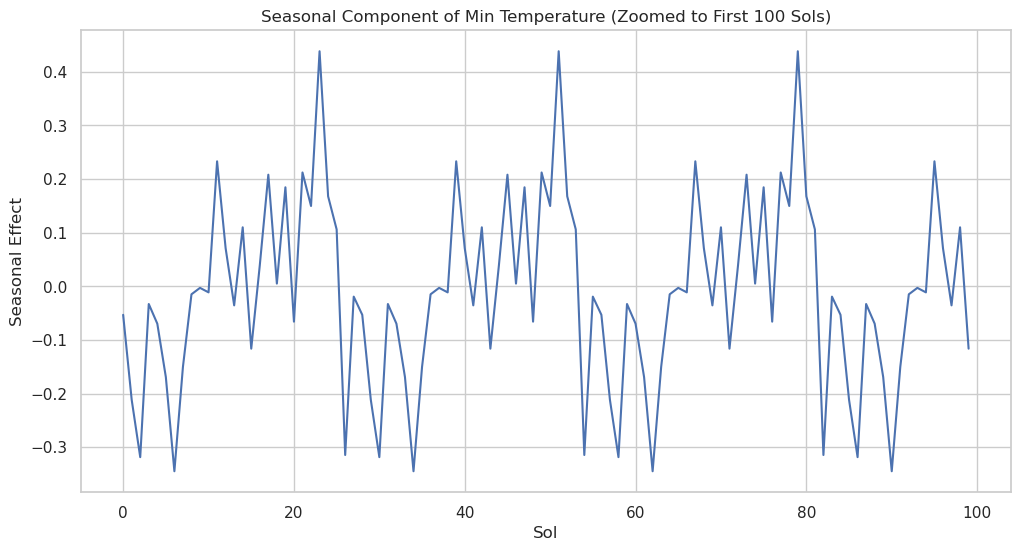

In [23]:
decomposition = seasonal_decompose(data_interp['min_temp'], period=28) #28 sols per martian month
plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal[:100])
plt.title("Seasonal Component of Min Temperature (Zoomed to First 100 Sols)")
plt.xlabel("Sol")
plt.ylabel("Seasonal Effect")
plt.grid(True)
plt.show()

In [24]:
decomposition = seasonal_decompose(data_interp['min_temp'], model='additive', period=28)

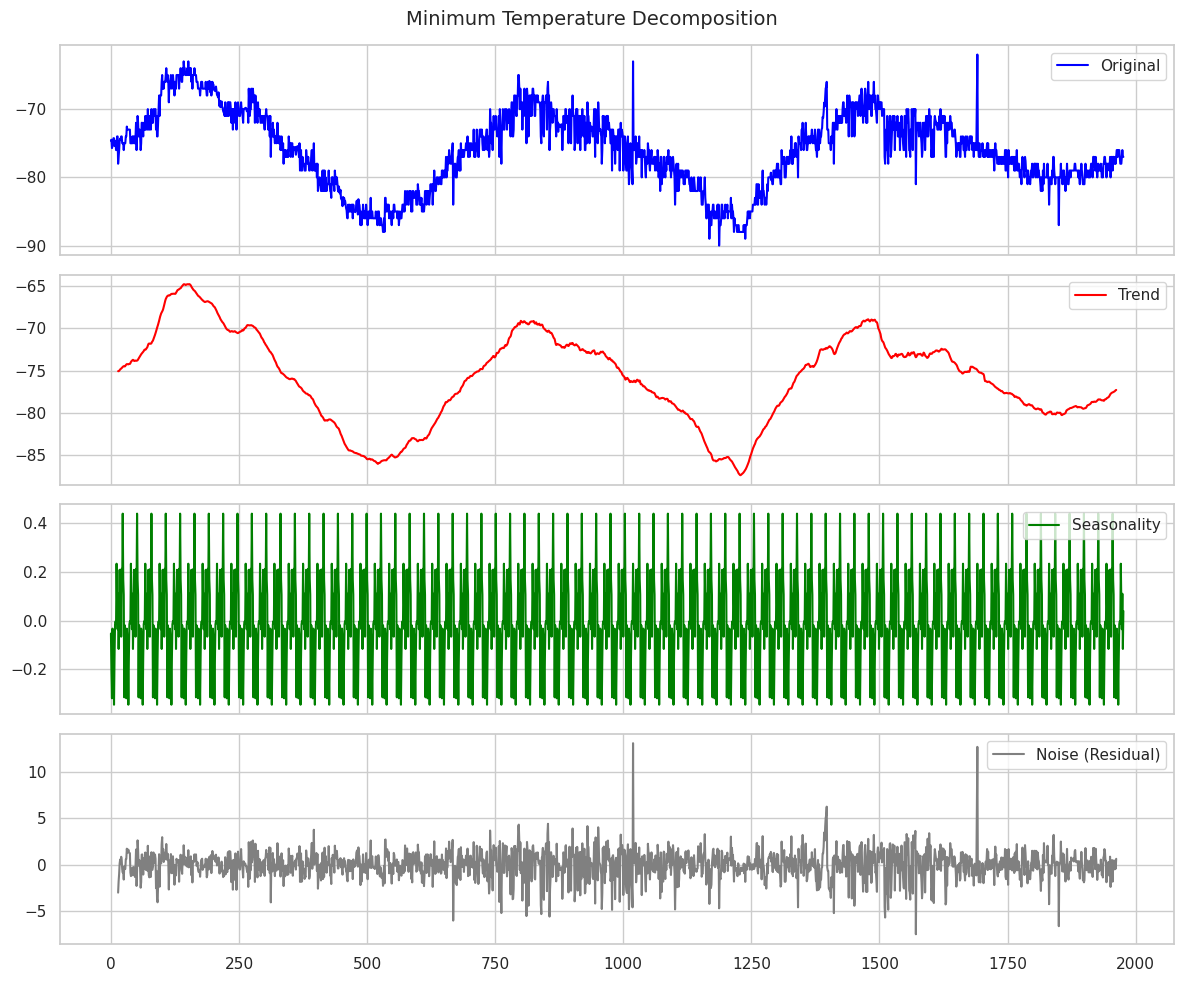

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(data_interp['min_temp'], label='Original', color='blue')
axes[0].legend()

axes[1].plot(decomposition.trend, label='Trend', color='red')
axes[1].legend()

axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
axes[2].legend()

axes[3].plot(decomposition.resid, label='Noise (Residual)', color='gray')
axes[3].legend()

plt.suptitle("Minimum Temperature Decomposition", fontsize=14)
plt.tight_layout()
plt.show()

#### Maximum Temperature Decomp

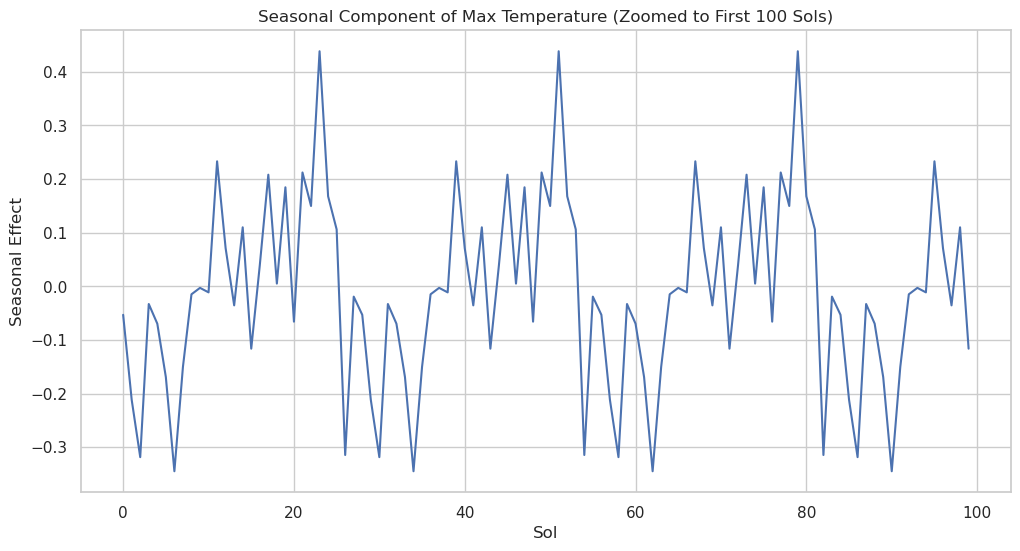

In [26]:
#-----Edit Line Below if Necessary----
max_decomposition = seasonal_decompose(data_interp['max_temp'], period=24)

plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal[:100])
plt.title("Seasonal Component of Max Temperature (Zoomed to First 100 Sols)")
plt.xlabel("Sol")
plt.ylabel("Seasonal Effect")
plt.grid(True)
plt.show()

In [27]:
max_decomposition = seasonal_decompose(data_interp['min_temp'], model='additive', period=30)

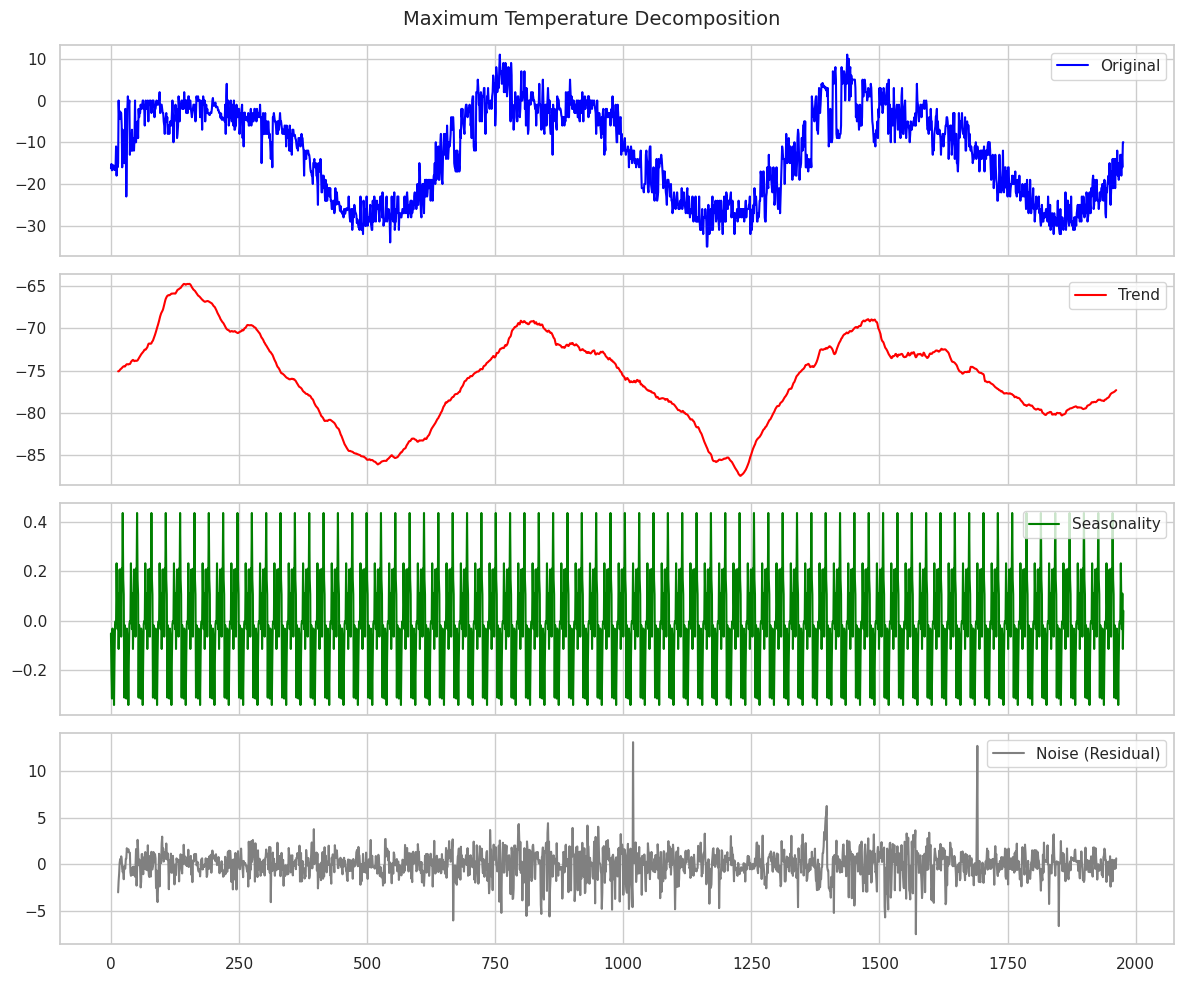

In [28]:
#----PLOT DATE FOR SEASONALITY COMPONENT-----
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(data_interp['max_temp'], label='Original', color='blue')
axes[0].legend()

axes[1].plot(decomposition.trend, label='Trend', color='red')
axes[1].legend()

axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
axes[2].legend()

axes[3].plot(decomposition.resid, label='Noise (Residual)', color='gray')
axes[3].legend()

plt.suptitle("Maximum Temperature Decomposition", fontsize=14)
plt.tight_layout()
plt.show()

#### Air Pressure Decomp

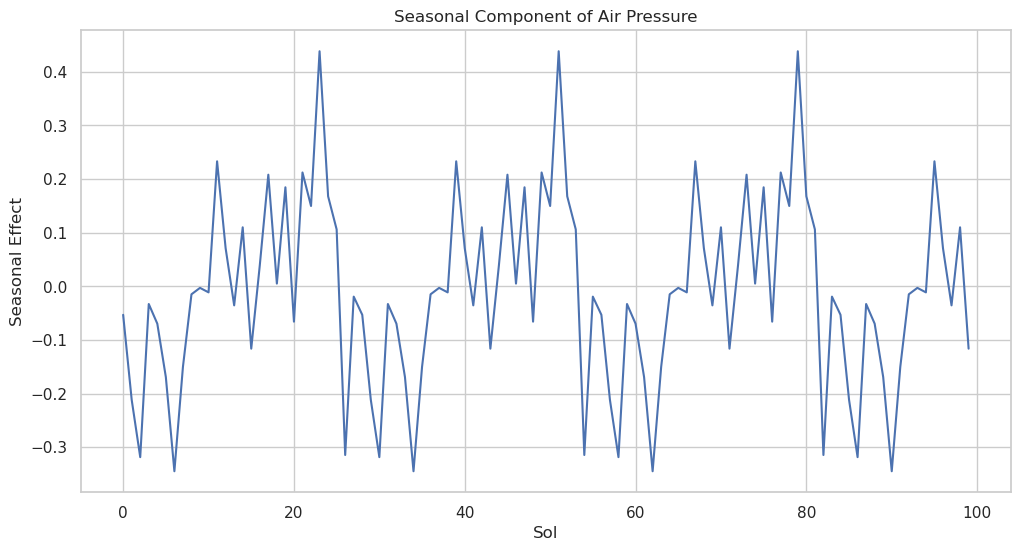

In [29]:
#----QUESTION HERE-----
#----can keep as is-----
air_decomposition = seasonal_decompose(data_interp['pressure'], period=28) #28 sols per martian month
plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal[:100])
plt.title("Seasonal Component of Air Pressure")
plt.xlabel("Sol")
plt.ylabel("Seasonal Effect")
plt.grid(True)
plt.show()

In [30]:
air_decomposition = seasonal_decompose(data_interp['min_temp'], model='additive', period=30)

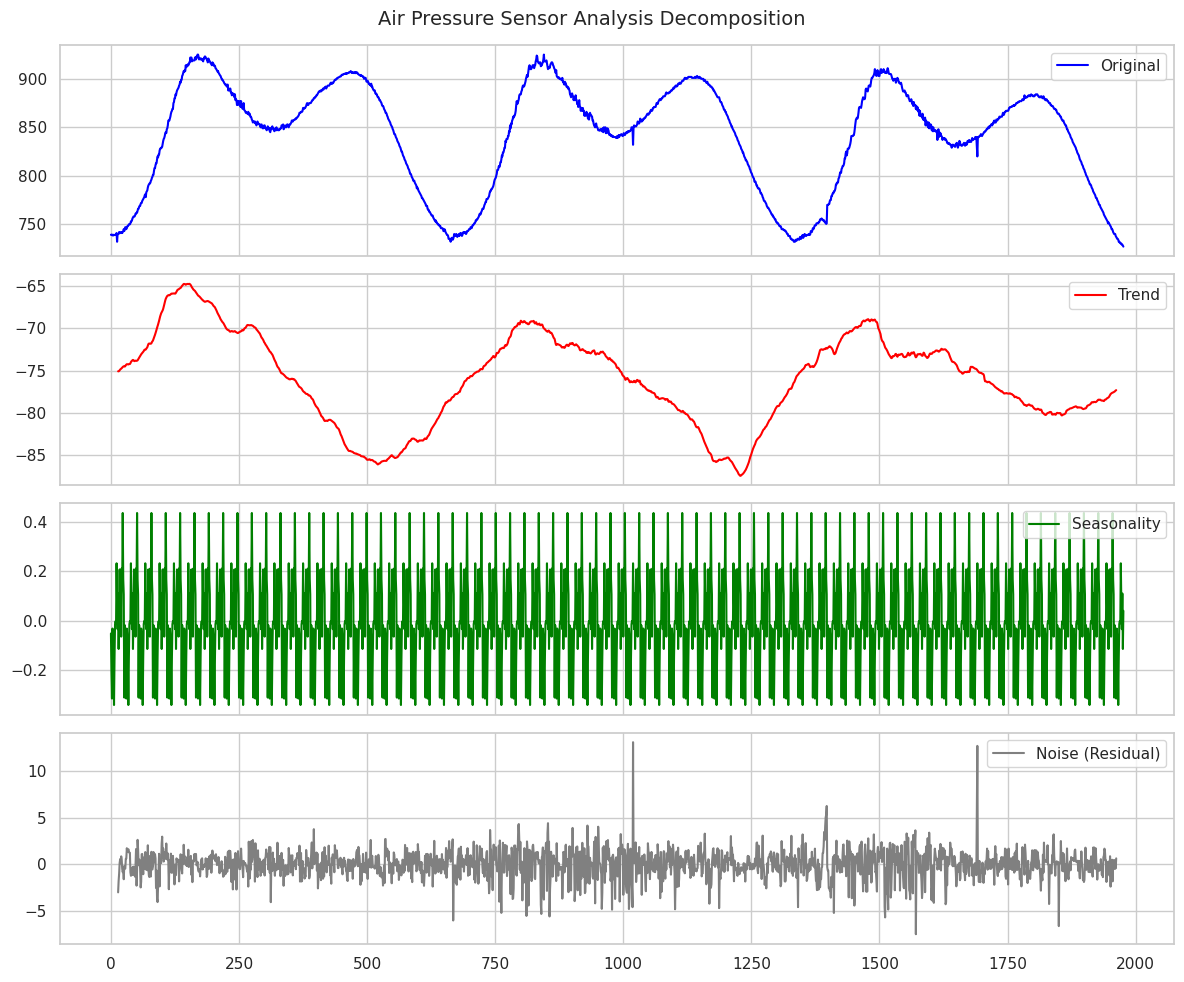

In [31]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(data_interp['pressure'], label='Original', color='blue')
axes[0].legend()

axes[1].plot(decomposition.trend, label='Trend', color='red')
axes[1].legend()

axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
axes[2].legend()

axes[3].plot(decomposition.resid, label='Noise (Residual)', color='gray')
axes[3].legend()

plt.suptitle("Air Pressure Sensor Analysis Decomposition", fontsize=14)
plt.tight_layout()
plt.show()

# Time Series Characteristics  
### Augmented Dickey-Fuller (ADF) Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary; meaning its statistical properties like mean and variance remain constant over time.

- **Null Hypothesis (H₀):** The time series has a unit root, implying it is non-stationary (may exhibit trends or seasonality).
- **Alternative Hypothesis (H₁):** The time series does not have a unit root, implying it is stationary.

The test will be performed over the necessary features in the dataset.
If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude the series is likely stationary.

In [32]:
result = adfuller(data_interp['min_temp'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Data is Stationary")
else:
    print("Data is NOT Stationary")

ADF Statistic: -1.4560759181028233
p-value: 0.5551173746541818
Data is NOT Stationary


In [33]:
result = adfuller(data_interp['max_temp'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Data is Stationary")
else:
    print("Data is NOT Stationary")

ADF Statistic: -1.67817074213892
p-value: 0.44239320268695076
Data is NOT Stationary


In [34]:
result = adfuller(data_interp['pressure'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Data is Stationary")
else:
    print("Data is NOT Stationary")

ADF Statistic: -7.641457595988307
p-value: 1.8910754119678706e-11
Data is Stationary


### Handling Non-Stationary Data with Differencing
The results of the ADF testing indicate that min and max average temperatures exhibit non-stationary behavior due to underlying seasonal patterns. To address this, the differencing technique will be applied to eliminate  trends and seasonality by transforming the series into a stationary one.

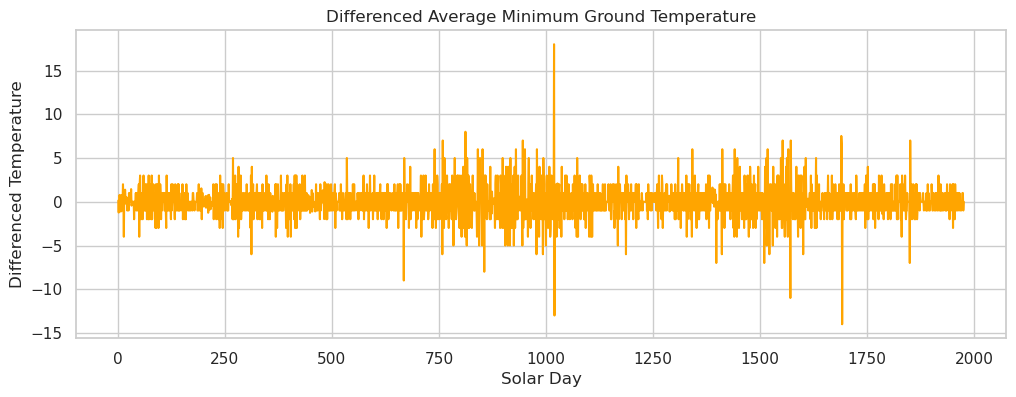

In [35]:
#----rename each diff column for each feature-----
data_interp['min_temp_diff'] = data_interp['min_temp'].diff()
plt.figure(figsize=(12,4))
plt.plot(data_interp['min_temp_diff'],color='orange')
plt.title("Differenced Average Minimum Ground Temperature")
plt.xlabel("Solar Day")
plt.ylabel("Differenced Temperature")
plt.show()

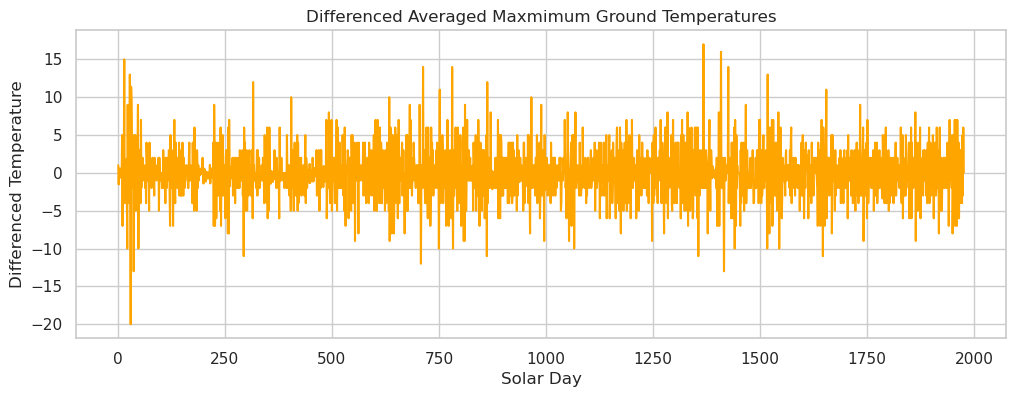

In [36]:
#----rename each diff column for each feature-----
data_interp['max_temp_diff'] = data_interp['max_temp'].diff()
plt.figure(figsize=(12,4))
plt.plot(data_interp['max_temp_diff'],color='orange')
plt.title("Differenced Averaged Maxmimum Ground Temperatures")
plt.xlabel("Solar Day")
plt.ylabel("Differenced Temperature")
plt.show()

In [37]:
data_interp.head(5)

sol  solar_long    month   min_temp   max_temp    pressure atmo_opacity  \
0    1       150.0  Month 6 -74.609508 -16.224465  739.229050        Sunny   
1    2       151.0  Month 6 -74.477499 -15.208288  738.929487        Sunny   
2    3       151.0  Month 6 -75.711346 -16.728044  739.446682        Sunny   
3    4       152.0  Month 6 -75.438515 -16.561733  738.780122        Sunny   
4    5       152.0  Month 6 -74.663263 -15.988497  738.379631        Sunny   

   min_temp_roll  max_temp_roll  pressure_roll  min_temp_diff  max_temp_diff  
0     -74.028246      -5.722576     751.578708            NaN            NaN  
1     -73.503771      -5.663973     751.575507       0.132009       1.016177  
2     -72.969500      -6.214389     752.053137      -1.233847      -1.519756  
3     -73.302716      -6.626050     751.986576       0.272831       0.166311  
4     -73.814819      -6.018160     750.763004       0.775253       0.573237

# Feature Engineering
### Lag Features
Lag features are created by shifting the time series backwards to include values from previous time steps. These features help capture temporal dependencies, or autocorrelation, where past values influence future ones.

In this project, we explore lag features for `min_temp`, `max_temp`, and `pressure`, since environmental variables are often autocorrelated. This is necessary for forecasting, as lag features can significantly improve model performance by giving it "memory" of past values.

In [38]:
data_feat_eng = data_interp.copy()
data_feat_eng['max_temp_lag_1'] = data_feat_eng['max_temp'].shift(1)
data_feat_eng['max_temp_lag_2'] = data_feat_eng['max_temp'].shift(28)


#### Rolling Statistics

In [39]:
data_feat_eng['max_temp_rolling_std_3'] = data_feat_eng['max_temp'].rolling(window=3).std()

#### Date/Time Features
Helps capture weekly, monthly, or yearly seasonality.

In [40]:
data_feat_eng.head(5)

sol  solar_long    month   min_temp   max_temp    pressure atmo_opacity  \
0    1       150.0  Month 6 -74.609508 -16.224465  739.229050        Sunny   
1    2       151.0  Month 6 -74.477499 -15.208288  738.929487        Sunny   
2    3       151.0  Month 6 -75.711346 -16.728044  739.446682        Sunny   
3    4       152.0  Month 6 -75.438515 -16.561733  738.780122        Sunny   
4    5       152.0  Month 6 -74.663263 -15.988497  738.379631        Sunny   

   min_temp_roll  max_temp_roll  pressure_roll  min_temp_diff  max_temp_diff  \
0     -74.028246      -5.722576     751.578708            NaN            NaN   
1     -73.503771      -5.663973     751.575507       0.132009       1.016177   
2     -72.969500      -6.214389     752.053137      -1.233847      -1.519756   
3     -73.302716      -6.626050     751.986576       0.272831       0.166311   
4     -73.814819      -6.018160     750.763004       0.775253       0.573237   

   max_temp_lag_1  max_temp_lag_2  max_temp_rolling_std_3  
0             NaN             NaN                     NaN  
1      -16.224465             NaN                     NaN  
2      -15.208288             NaN                0.774152  
3      -16.728044             NaN                0.833580  
4      -16.561733             NaN                0.387984

In [41]:
# fit an arima model on one of the variable targets 
# consider how far forward to forecast
# try to fit model
# based on output of arima model, utilize sarima, sarimax on that variable (only sarmiax for external variable)
# compare model accuracy

# 🔍 Autocorrelation and Partial Autocorrelation Analysis

To better understand the temporal dependencies in our differenced data, I will use **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots. These statistical tools help uncover the internal structure of the time series and are essential for selecting parameters in time series models such as ARIMA.

- **ACF (Autocorrelation Function)** shows the correlation of a time series with its past values (lags). It is typically used to determine the appropriate order of the **Moving Average (MA)** component in time series models.
- **PACF (Partial Autocorrelation Function)** shows the correlation between the time series and its lagged values, controlling for the values of the intervening lags. It is used to determine the order of the **Auto-Regressive (AR)** component.

Since our original `max_temp` time series exhibited seasonality and non-stationarity, I applied first-order differencing to transform it into a stationary series. The ACF and PACF plots are applied to this differenced feature, `max_temp_diff`, to help detect meaningful lag structures and guide model selection.



In [42]:
max_temp_diff_data = data_interp['max_temp_diff']

Reconducted ADF tested to ensure data is sufficiently stationary:

In [43]:
result = adfuller(max_temp_diff_data.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Data is Stationary")
else:
    print("Data is NOT Stationary")

ADF Statistic: -13.660617041630823
p-value: 1.5239333909506631e-25
Data is Stationary


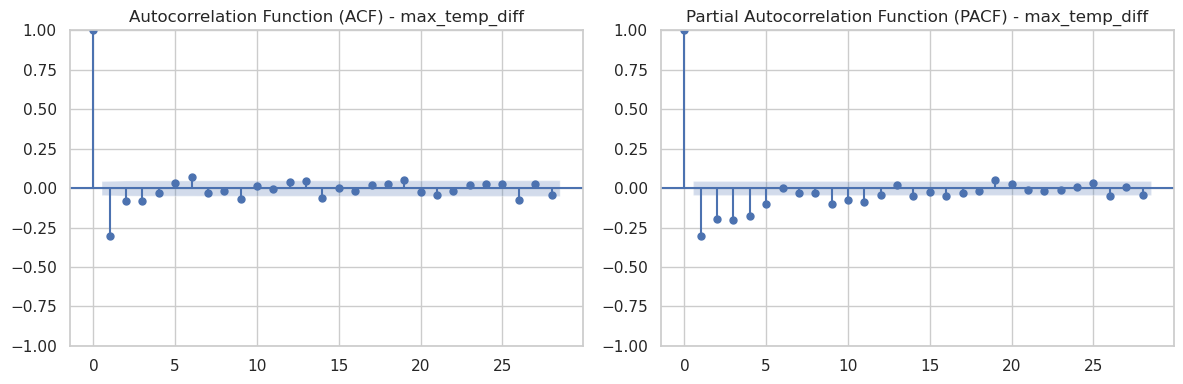

In [44]:
# Set figure size
plt.figure(figsize=(12, 4))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(max_temp_diff_data.dropna(), lags=28, ax=plt.gca())
plt.title("Autocorrelation Function (ACF) - max_temp_diff")

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(max_temp_diff_data.dropna(), lags=28, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF) - max_temp_diff")

plt.tight_layout()
plt.show()

# Model Forecasting

### ARIMA Modeling Overview

The **ARIMA** model technique is implemented for time series forecasting. It has three main parameters:

- **p**: the number of autoregressive terms (AR)
- **d**: the number of times the data needs to be differenced to become stationary (Integration)
- **q**: the number of moving average terms (MA)

#### Determining ARIMA Parameters (p, d, q)

- **d (Integration)**  
  This is determined by how many times was needed to difference the data to make it stationary.  
  In this case, since only one differencing was needed based on the Augmented Dickey-Fuller test results,  
  we set:  
  `d = 1`

- **p (Autoregressive)**  
  This is determined by analyzing the **Partial Autocorrelation Function (PACF)** plot.  
  Look for the lag after which the PACF plot drops off (i.e. becomes insignificant).  
  That lag is a good choice for `p`.

- **q (Moving Average)**  
  This is determined by analyzing the **Autocorrelation Function (ACF)** plot.  
  Look for the lag after which the ACF plot drops off — this lag value is used as `q`.

#### Example

If:
- PACF plot cuts off sharply after lag 2 → `p = 2`
- ACF plot cuts off after lag 1 → `q = 1`
- Differencing once made the data stationary → `d = 1`

Then:
```python
ARIMA(order=(2, 1, 1))
```

### Auto ARIMA

To determine the optimal parameters for our ARIMA model, the `auto_arima` function is applied. This automates the process of selecting the best values for the three main parameters

Auto ARIMA evaluates multiple combinations and selects the best model using the Akaike Information Criterion (AIC). This helps ensure that the model balances complexity and performance without overfitting.

Since our data already required diffrencing to achieve stationarity, I allowed the model to determine the appropriate `d` value as well.

In [45]:
auto_arima_model = pm.auto_arima(
    data_interp['max_temp'].dropna(),
    seasonal=False,         # no seasonality because ARIMA
    trace=True,             # print output as it tries options
    error_action='ignore',  # ignore errors
    suppress_warnings=True,
    stepwise=True           # fast search
)

# View the chosen parameters
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10051.620, Time=3.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10496.908, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10304.078, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10149.678, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10494.910, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10051.295, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10068.949, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10049.574, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10051.250, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10228.886, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10047.576, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10147.684, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10302.081, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10049.252, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0

To generate a forecast a forecast horizon is defined equal to one Martian year (approximately 669 sols). We begin forecasting at the index immediately following the last observed data point.

- **start**: the index where the forecast begins (`len(data)`)
- **end**: the index where the forecast ends (`len(data) + end`)

This allows to project the seasonal behavior of the selected variable into the next Martian year based on past trends and seasonal patterns.

In [46]:
start = len(data_interp)
end = start + (669)

In [47]:
arima_model =  ARIMA(data_interp['max_temp'], order = (1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:               max_temp   No. Observations:                 1977
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5020.788
Date:                Mon, 28 Jul 2025   AIC                          10047.576
Time:                        19:56:39   BIC                          10064.343
Sample:                             0   HQIC                         10053.736
                               - 1977                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3696      0.026     14.156      0.000       0.318       0.421
ma.L1         -0.8407      0.016    -53.095      0.000      -0.872      -0.810
sigma2         9.4269      0.227     41.574      0.0

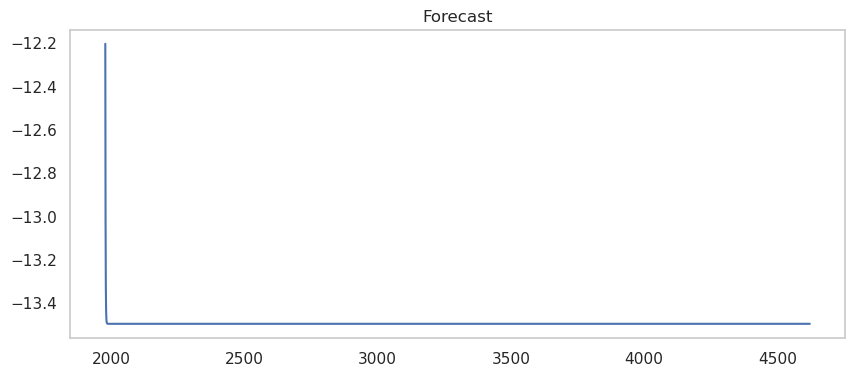

In [48]:
arima_forecast = arima_result.forecast(steps=end)
arima_forecast.plot(title="Forecast", figsize=(10, 4))
plt.grid()
plt.show()

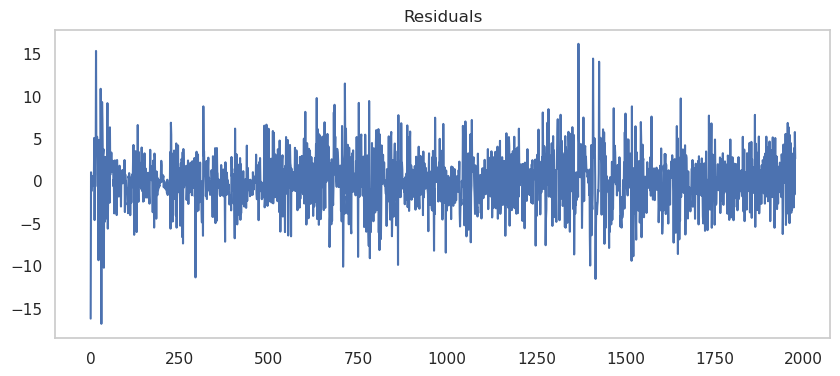

In [49]:
arima_residuals = arima_result.resid
arima_residuals.plot(title="Residuals", figsize=(10, 4))
plt.grid()
plt.show()

In [50]:
arima_forecast = arima_result.predict(start, end, typ='levels')
arima_forecast_index = np.arange(start, end + 1)
arima_forecast_df = pd.DataFrame({'Sol': arima_forecast_index, 'ARIMA_Forecast': arima_forecast})

### SARIMA Modeling

To capture both trend and **seasonal patterns** in the `max_temp` time series, a SARIMA model is applied. Unlike regular ARIMA, SARIMA introduces seasonal terms (P, D, Q, s) to explicitly model cyclic behavior. This is particularly useful for Martian environmental data, where temperature changes follow periodic trends aligned with the Martian calendar.

The model is defined as SARIMA(p, d, q)(P, D, Q, s), where:
- `d = 1` was used because one level of differencing was sufficient to achieve stationarity.
- The seasonal period `s` is set to the perceived monthly seasonality of the decomposed ```max_temp``` data of ```28```.

In [51]:
# auto_saima_model = pm.auto_arima(
#     data_interp['max_temp'],     # original time series (not differenced)
#     seasonal=True,               # SARIMA (not just ARIMA)
#     m= 30,                        # (observed seasonality in decomposed max_temp)
#     trace=True,                  # prints progress
#     error_action='ignore',      # don't break on errors
#     suppress_warnings=True,     # ignore warnings
#     stepwise=True                # faster search method
# )

# # View the selected parameters
# print(auto_sarima_model.summary())

In [52]:
sarima_model = SARIMAX(data_interp['max_temp'], order = (1, 1, 1), seasonal_order = (1, 1, 1, 28))
sarima_result = sarima_model.fit()
print(sarima_result.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68041D+00    |proj g|=  8.96413D-02

At iterate    5    f=  2.54714D+00    |proj g|=  2.32788D-02

At iterate   10    f=  2.53462D+00    |proj g|=  8.71099D-03

At iterate   15    f=  2.53312D+00    |proj g|=  1.43750D-03

At iterate   20    f=  2.53301D+00    |proj g|=  1.09285D-03

At iterate   25    f=  2.53299D+00    |proj g|=  1.63528D-04

At iterate   30    f=  2.53298D+00    |proj g|=  9.47941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [53]:
sarima_forecast = sarima_result.predict(start=start, end=end)
sarima_forecast_df = pd.DataFrame({'Sol': arima_forecast_index, 'SARIMA_Forecast': sarima_forecast})

### Comparing Forecasts: ARIMA vs. SARIMA

This following visualization compares the actual max temperature readings from the Curiosity Rover with two forecasting models:

- **ARIMA Forecast**: Captures the overall trend in the data but does not model seasonality.
- **SARIMA Forecast**: Accounts for both trend and seasonal patterns.

By overlaying both forecasts against the real observed values, the accuracy of how each model fits and extends the data into the future can be visually assessed.

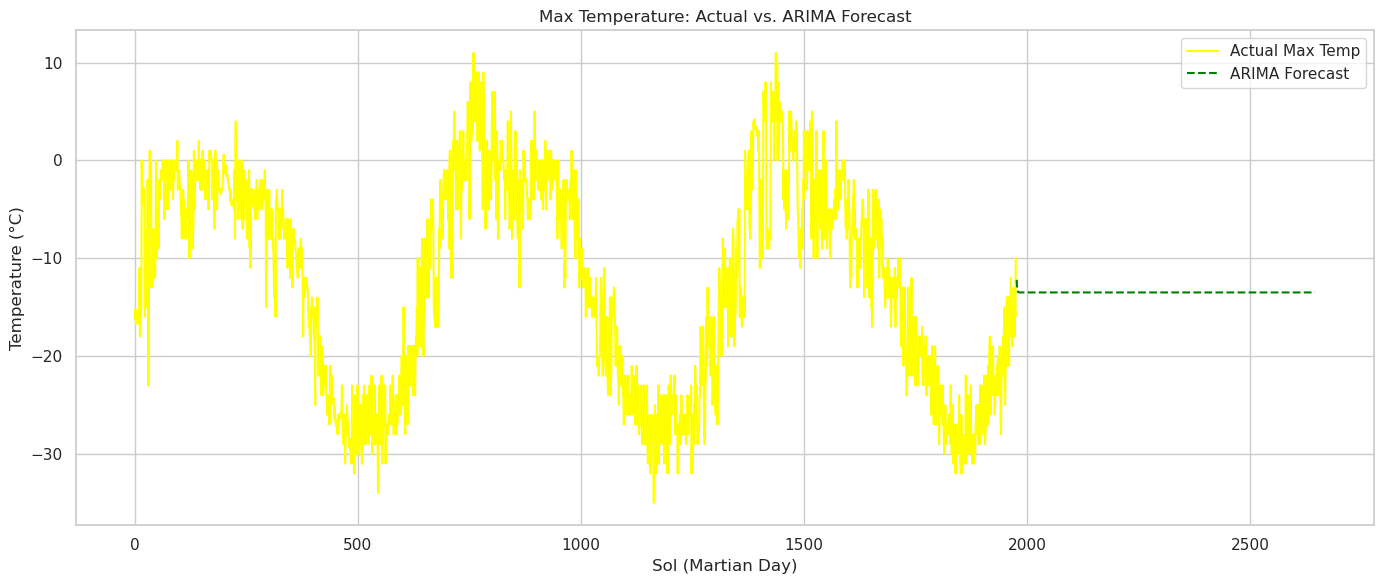

In [54]:
# 6. Plot actual data and forecasts
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(data_interp.index, data_interp['max_temp'], label='Actual Max Temp', color='yellow')

# Plot ARIMA forecast
plt.plot(arima_forecast_df['Sol'], arima_forecast_df['ARIMA_Forecast'], label='ARIMA Forecast', color='green', linestyle='--')

plt.title("Max Temperature: Actual vs. ARIMA Forecast")
plt.xlabel("Sol (Martian Day)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

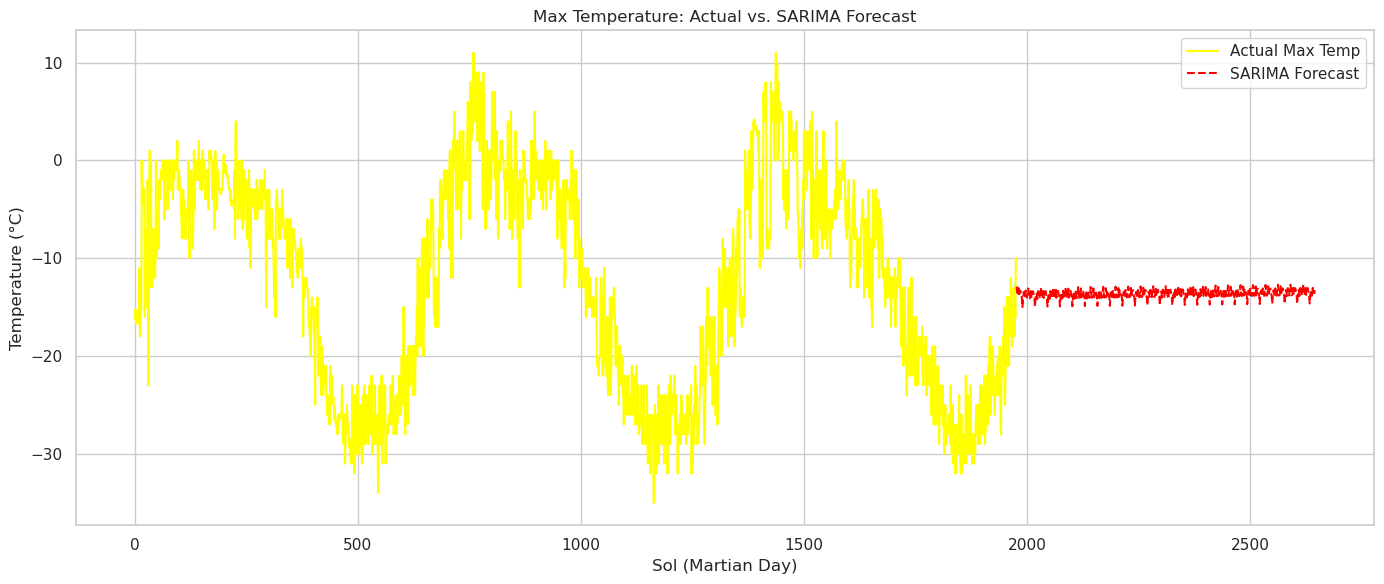

In [55]:
# 6. Plot actual data and forecasts
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(data_interp.index, data_interp['max_temp'], label='Actual Max Temp', color='yellow')
# Plot SARIMA forecast
plt.plot(sarima_forecast_df['Sol'], sarima_forecast_df['SARIMA_Forecast'], label='SARIMA Forecast', color='red', linestyle='--')
plt.title("Max Temperature: Actual vs. SARIMA Forecast")
plt.xlabel("Sol (Martian Day)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression Modeling

After generating new features through time series feature engineering—such as rolling means, differencing, and lag values—regression modeling becomes a powerful tool for understanding and quantifying the relationship between environmental variables on Mars.

Regression allows for:
- **Capture linear or non-linear trends** in the engineered features over time.
- **Predict future values** based on multiple input features simultaneously.
- **Assess variable importance**, helping to identify which environmental factors (e.g., pressure, temperature changes) most influence Martian weather conditions.

### Features and Targets

In [56]:
data_feat_eng['target_class'] = (data_feat_eng['max_temp'].shift(-1) > data_feat_eng['max_temp']).astype(int)# classification label

In [63]:
features = ['max_temp_roll', 'max_temp_diff', 'max_temp_lag_1', 'max_temp_lag_2', 'max_temp_rolling_std_3']
X = data_feat_eng[features].dropna()
y_reg = data_feat_eng['max_temp']
y_clf = data_feat_eng['target_class']

# drop rows with any NaNs in X or targets to keep things aligned
combined = pd.concat([X, y_reg, y_clf], axis=1).dropna()
X = combined[features]
y_reg = combined['max_temp']
y_clf = combined['target_class']

### Time Aware Train Split 80/20

In [64]:
split_idx = int(len(data_feat_eng) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_reg_train, y_reg_test = y_reg[:split_idx], y_reg[split_idx:]
y_clf_train, y_clf_test = y_clf[:split_idx], y_clf[split_idx:]

In [65]:
#store results
results = {}

### Regression Models

In [66]:
models_reg = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=5),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'XGBoost': xgb.XGBRegressor(),
}

for name, model in models_reg.items():
    model.fit(X_train, y_reg_train)
    preds = model.predict(X_test)
    results[name] = {
        "RMSE": mean_squared_error(y_reg_test, preds, squared=False),
        "MAE": mean_absolute_error(y_reg_test, preds),
        "R2": r2_score(y_reg_test, preds)
    }

### Classification Models

In [68]:
models_clf = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVM': SVC()
}

class_results = {}
for name, model in models_clf.items():
    model.fit(X_train, y_clf_train)
    preds = model.predict(X_test)
    class_results[name] = {
        "Accuracy": accuracy_score(y_clf_test, preds),
        "Report": classification_report(y_clf_test, preds, output_dict=True)
    }

results["Classification"] = class_results

In [69]:
# ---- Format and display Regression results as a table ----
print("\nProcessing Regression Results:")
regression_data = {}
for k in tqdm([k for k in results if k != "Classification"], desc="Formatting Regression"):
    regression_data[k] = results[k]

regression_results = pd.DataFrame(regression_data).T
regression_results = regression_results.sort_values(by="RMSE")
print("\n Regression Model Comparison:")
print(regression_results)


# ---- Format and display Classification results as a table ----
print("\nProcessing Classification Results:")
classification_data = {}
for name in tqdm(results["Classification"], desc="Formatting Classification"):
    metrics = results["Classification"][name]
    classification_data[name] = {
        "Accuracy": round(metrics["Accuracy"], 3),
        "Precision (1)": round(metrics["Report"]["1"]["precision"], 3),
        "Recall (1)": round(metrics["Report"]["1"]["recall"], 3),
        "F1-score (1)": round(metrics["Report"]["1"]["f1-score"], 3)
    }

classification_results = pd.DataFrame(classification_data).T
classification_results = classification_results.sort_values(by="Accuracy", ascending=False)
print("\n Classification Model Comparison:")
print(classification_results)


Processing Regression Results:


Formatting Regression: 100%|██████████| 4/4 [00:00<00:00, 14193.92it/s]



 Regression Model Comparison:
                          RMSE           MAE        R2
LinearRegression  1.145648e-14  9.504475e-15  1.000000
XGBoost           5.620748e-01  3.890339e-01  0.994620
RandomForest      6.027518e-01  4.213130e-01  0.993814
DecisionTree      2.243822e+00  1.788298e+00  0.914268

Processing Classification Results:


Formatting Classification: 100%|██████████| 3/3 [00:00<00:00, 20661.60it/s]


 Classification Model Comparison:
                        Accuracy  Precision (1)  Recall (1)  F1-score (1)
LogisticRegression         0.682          0.700       0.509         0.589
SVM                        0.649          0.680       0.412         0.513
RandomForestClassifier     0.595          0.557       0.473         0.511


In [71]:

# ---- Identify Best Regression Model ----
print("\nSelecting Best Regression Model:")
for _ in tqdm(range(1), desc="Evaluating Regression"):  # Simulated for effect
    best_reg = regression_results.sort_values(by="RMSE").index[0]
    best_reg_rmse = regression_results.loc[best_reg, 'RMSE']
    time.sleep(0.1)  # Simulate processing delay (optional)

# ---- Identify Best Classification Model ----
print("\nSelecting Best Classification Model:")
for _ in tqdm(range(1), desc="Evaluating Classification"):  # Simulated for effect
    best_clf = classification_results.sort_values(by="Accuracy", ascending=False).index[0]
    best_clf_acc = classification_results.loc[best_clf, 'Accuracy']
    time.sleep(0.1)

# ---- Print Best Models ----
print("\n Best Performing Models:")
print(f"- Regression: {best_reg} (Lowest RMSE = {best_reg_rmse:.2f})")
print(f"- Classification: {best_clf} (Highest Accuracy = {best_clf_acc:.2f})")


Selecting Best Regression Model:


Evaluating Regression: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]



Selecting Best Classification Model:


Evaluating Classification: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


 Best Performing Models:
- Regression: LinearRegression (Lowest RMSE = 0.00)
- Classification: LogisticRegression (Highest Accuracy = 0.68)


# Conclusion & Impact

The **Linear Regression model** achieved near-perfect performance with an RMSE close to zero and an R² of 1.0, suggesting that the engineered features—particularly lagged values, rolling averages, and differencing—provided an exceptionally accurate basis for predicting Martian surface temperatures. While more complex models like XGBoost and Random Forest also performed well, the simplicity and efficiency of Linear Regression make it highly interpretable and practical for deployment in low-resource environments.

On the classification side, **Logistic Regression** achieved the highest accuracy (68%), outperforming more complex models like SVM and Random Forest in predicting whether the next day's maximum temperature would rise. Although there's room for improvement in recall and F1-score, the results show that even with limited labeled data, meaningful classification is achievable.

### 🔭 Mission Relevance

These results align directly with the project’s objective: **enhancing data reliability and predictive capabilities in hostile, data-limited environments like Mars**. Specifically:

- ✅ **Robust Feature Engineering**: Time series transformations (e.g., differencing, rolling statistics, lag features) enabled accurate modeling despite seasonal noise and non-stationarity in the data.
- ✅ **Model Efficiency**: Linear and logistic regression are lightweight models, making them ideal for real-time, onboard computations on resource-constrained hardware—common in space robotics and autonomous mission control.
- ✅ **Forecasting for Autonomy**: Accurate temperature predictions allow robotic systems to better anticipate thermal challenges (e.g., component strain, battery performance), improving their ability to operate autonomously.
- ✅ **Fault Detection & Planning**: Classification of temperature shifts can serve as early-warning indicators for anomalous environmental patterns, contributing to preemptive hazard response or mission re-planning.

Ultimately, this project demonstrates how thoughtful time series modeling and regression/classification approaches can turn raw environmental sensor data into actionable intelligence—**a critical capability for sustaining future robotic and human missions in extreme planetary environments.**


In [ ]:
# when done & understand - EXPLORE LSTM MODELLING